# Building your own Object Detector from scratch

This exercise is based on notebook from doleron (https://github.com/doleron/simple-object-detector-from-scratch). The original notebook is further explained in a story on medium: https://medium.com/@doleron/building-your-own-object-detector-from-scratch-bfeadfaddad8. The data is taken from https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet.

The object detector, which will be build on Tensorflow and Keras, will detect people where some people do and some do not wear masks.

## 1 Imports

In [2]:
import pathlib  # Creating paths independentyl of the file system
import shutil   # Unpacking zip
import cv2 as cv    # Image processing
import numpy as np  # Working with vectors and matrices
from matplotlib import pyplot as plt  # Printing images, plotting graphs  
import os   # Accessing the file system
import random   # Create random order for the dataset
import tensorflow as tf # Building the model

## 2 Reading in the data

The data is given to you as a zip archive. It contains images of people that do or do not wear masks. Additionally it contains annotations for each picture.

In [3]:
# unpack the archive
shutil.unpack_archive("data/archive.zip", "data/")

data_dir = pathlib.Path("data/obj/").with_suffix('')

# Store all images in image_files
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


**Expected Output**: 1510

As the archive is unpacked, we can now have a look at a sample image. 

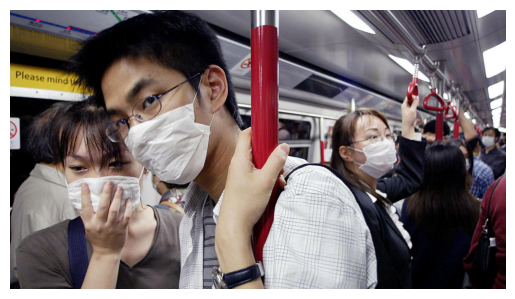

In [5]:
# print image[0]
sample_img_path = str(image_files[0])
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

For each picture the data provides a text file with according annotations. Each annotation consists of five values. The first value denotes the class where 0 stands for a person wearing a mask and 1 standing for a person not wearing a mask.
The following four values describe a bounding box over the persons head. The values represent the x, y, width and height of the box.

#### Exercise: Get the right annotation
The annotations are stored in '.txt' files that, apart from the file extension, have the same name as the images. Your first task is to get the path to the image that you just printed. 

Hint: To get every but the last four characters from a string use example_string[0:-4].

In [5]:
### START CODE HERE ### (≈ 1 line)
sample_annotation_path = sample_img_path[0:-4] + '.txt'
### END CODE HERE ###
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.4734375 0.5739030023094688 0.665625 0.5612009237875288\n']


**Expected output:**
['0 0.4734375 0.5739030023094688 0.665625 0.5612009237875288\n']

The following function filter the files, generating 3 lists:

- training files (70% of images)
- validation files (20% of images)
- test files (last 10%)

In [6]:
def list_files(full_data_path = "data/obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [7]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


This is actually a small dataset. We have only 904 images to train our model!

Let's combine image and annotations in order to check if we actually understand how to deal with the data.

In addition, let's format the images for the input size of our model (244 x 244)

#### **Exercise**: Convert the data
The images in the dataset have varying dimensions. The model we are going to build expects images of size 244x244 as input. Therefore, your next task is to convert the images to the right size. Because we change the size of the images, the position and size of the boxes also has to be adjusted.

Hints:
- By deviding the bigger of the two image dimensions through the input_size of the model, you will get a factor by which you can scale your images width and height
- 'new_size' should be a tuple containing the new width and height (new_size = (new_width, new_height))
- Round all results to the nearest integer


In [56]:
input_size = 244

def format_image(img, box):
    """Format images and boxes to fit the input size of the model (244x244)

    Arguments:
    img -- array of shape (height, width)
    box -- array of shape (4), containing the boxes x, y, width and height

    Returns:
    new_image -- array of shape (244x244), containing the reshaped image
    new_box -- array of shape (4), containing the formatted box
    """

    # Calculate the new_size of the image
    ### START CODE HERE ### (≈ 5 lines)
    height, width = img.shape 
    max_size = max(height, width)
    r =  input_size / max_size
    new_width = int(width * r)
    new_height = int(height * r)
    new_size = (new_width, new_height)
    ### END CODE HERE ###

    # Resize the image to the calcualted size and fill the smaller dimension with black pixels (zeros) to get a 244x244 image
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width * r), int((y - 0.5*h) * height * r), int(w*width * r), int(h*height * r)]

    return new_image, new_box

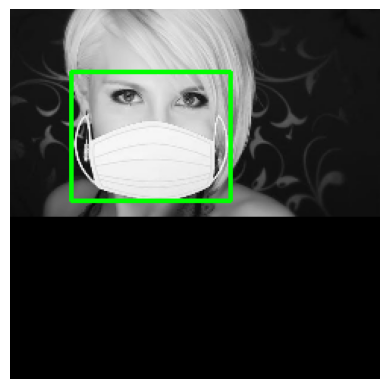

original image shape  (350, 622)
formatted image shape  (244, 244)


In [57]:
temp_img = cv.imread("data/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()
print("original image shape ", temp_img.shape)
print("formatted image shape ", temp_img_formated.shape)

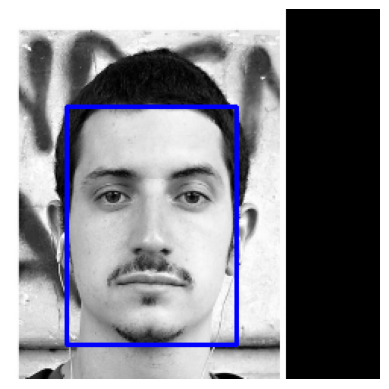

In [10]:
temp_img = cv.imread("data/obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

The dataset is composed by different images of peoplse using or not masks. Let's create a tensorflow dataset with the images:

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print(tf.__version__)

2.12.0


In [12]:
def data_load(files, full_data_path = "data/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [13]:
raw_train_ds = data_load(training_files)

In [14]:
raw_validation_ds = data_load(validation_files)

In [15]:
raw_test_ds = data_load(test_files)

The training, validation & test datasets must be set up in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [16]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [17]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
train_ds = tune_training_ds(raw_train_ds)

In [19]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [20]:
validation_ds = tune_validation_ds(raw_validation_ds)

Let's inspect our training dataset:

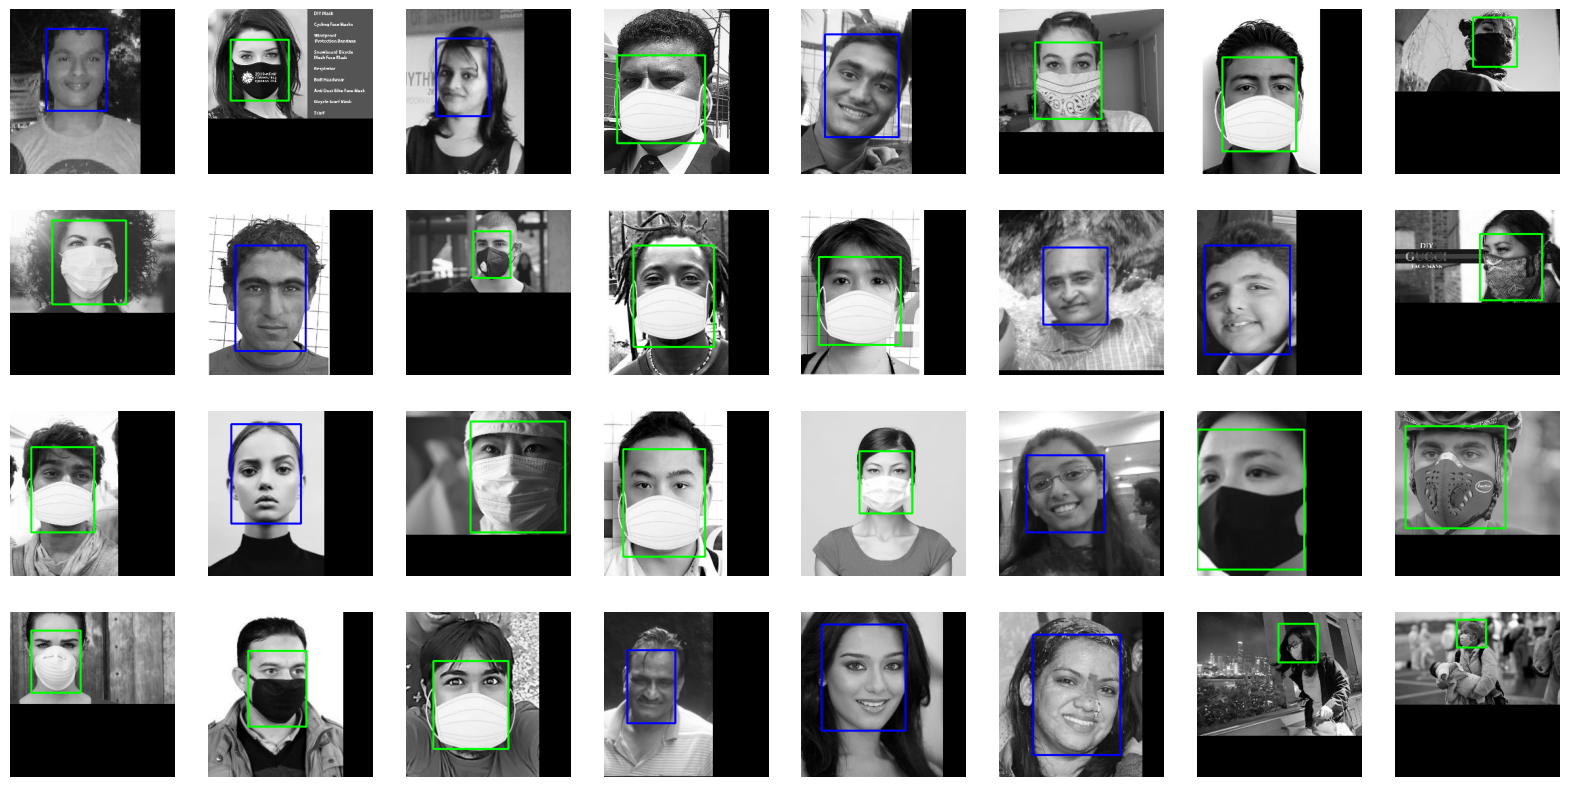

In [21]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Based on the image above, we can realize that the training dataset is correctly set. Blue rectangles represent bounding box of **unmask people**. A green rectangle represent a masked person. 

Once the data is ready, we can start our modelling and training.

## The model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Funcional API, as follows: 

In [22]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

It is notewhortly that each network head has a specific set of loss function and metrics:

In [23]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 242, 242, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 121, 121, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

Since we have few data, we must keep the model small. The model can be vizualized below:

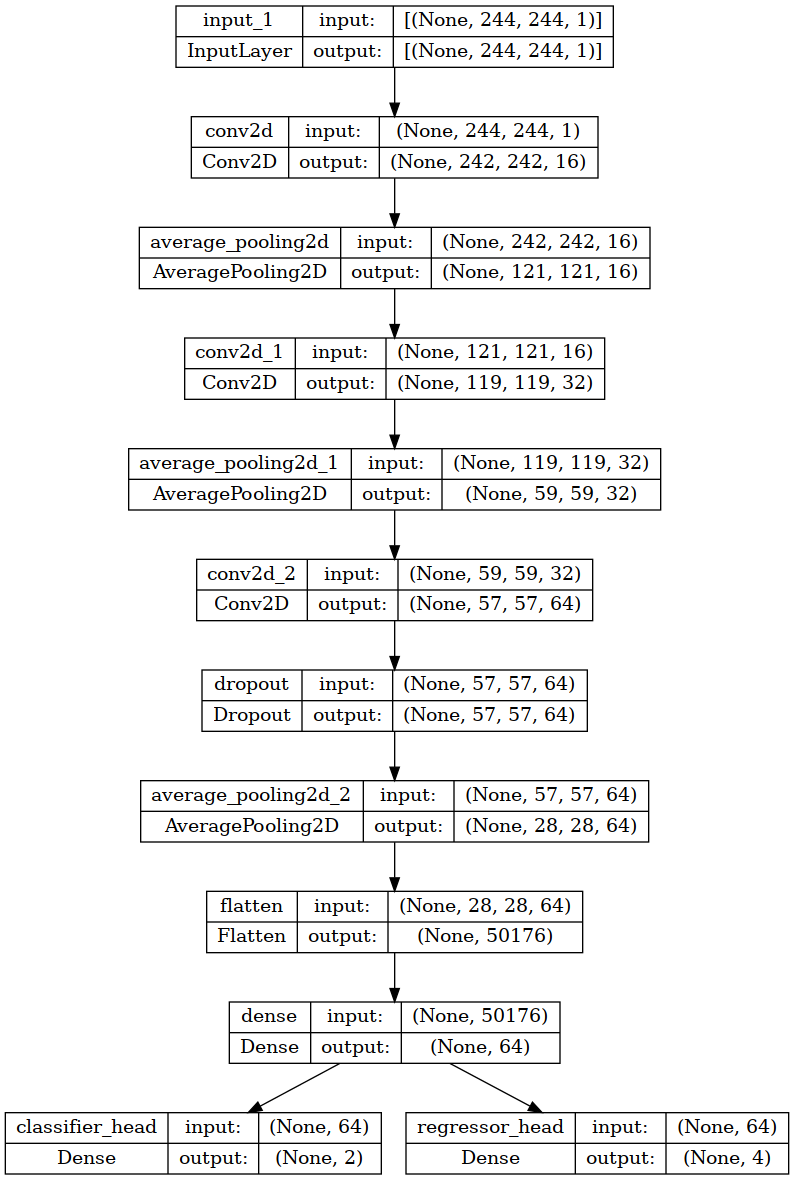

In [24]:
# plot_model requires graphviz & pydot
# see https://github.com/XifengGuo/CapsNet-Keras/issues/7#issuecomment-370745440
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## Model training

Our model is all set and we can start the training, as shown in the next cell:

In [25]:
EPOCHS = 5

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS)

Epoch 1/5


28/28 [==============================] - 20s 644ms/step - loss: 0.8318 - classifier_head_loss: 0.6518 - regressor_head_loss: 0.1801 - classifier_head_accuracy: 0.6462 - regressor_head_mse: 0.1801 - val_loss: 0.5646 - val_classifier_head_loss: 0.5412 - val_regressor_head_loss: 0.0234 - val_classifier_head_accuracy: 0.7344 - val_regressor_head_mse: 0.0234
Epoch 2/5
28/28 [==============================] - 16s 584ms/step - loss: 0.6130 - classifier_head_loss: 0.5925 - regressor_head_loss: 0.0206 - classifier_head_accuracy: 0.6574 - regressor_head_mse: 0.0206 - val_loss: 0.4956 - val_classifier_head_loss: 0.4743 - val_regressor_head_loss: 0.0213 - val_classifier_head_accuracy: 0.7344 - val_regressor_head_mse: 0.0213
Epoch 3/5
28/28 [==============================] - 16s 585ms/step - loss: 0.5880 - classifier_head_loss: 0.5681 - regressor_head_loss: 0.0199 - classifier_head_accuracy: 0.6931 - regressor_head_mse: 0.0199 - val_loss: 0.4840 - val_classifier_head_loss: 0.4638 - val_regressor_he

The training performance can be checked in the charts below. 

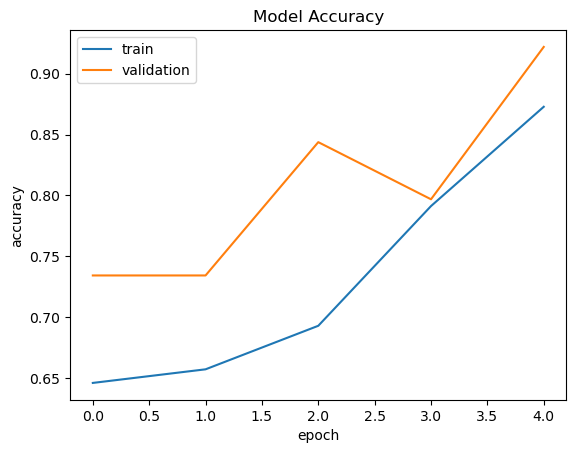

In [26]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

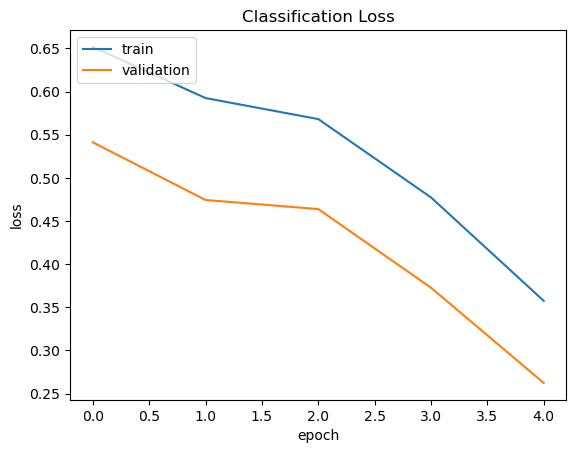

In [27]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

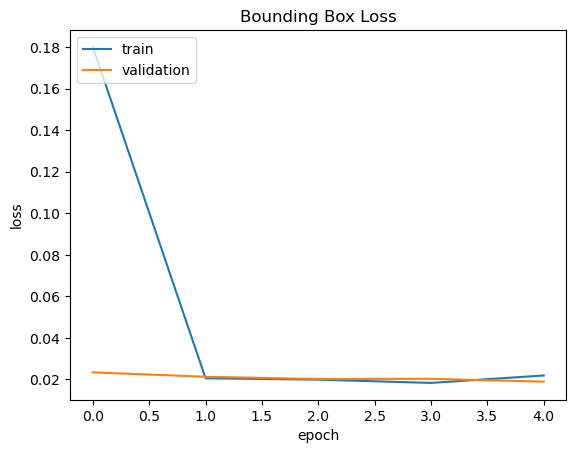

In [28]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

The best way to evaluate the end model performance is by using IoU - intersection over Union - metrics. The following implementation of IoU was adapted from PyImage Search website:

In [29]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [30]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

The model performance is finally evaluated on the test dataset. Green boxes indicaates correct classification in which the predicted label (masked-unmasked) matches with the actual label.
A red box indicate a wrong classification.

20


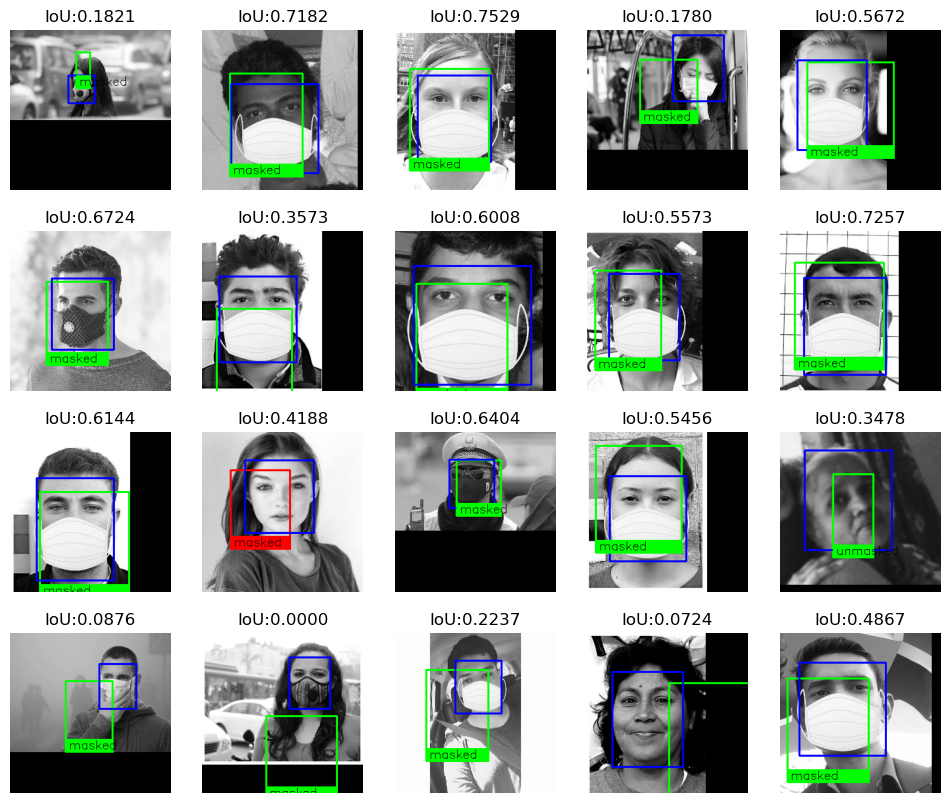

In [31]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## Conclusion

Taking in consideration the small size of the data used for training and the fact of training the model from scratch without transfer learning, the results above are surprisingly good. We can think in ways to improve it even more:

- The first option to improve the bound box and classificataion performance is increase the training data size which can be easily achieved by data augmentation.

- Tweaking the hyperparameters and finding on way to improve the regularization can either improve the results, reducing the classification and regression errors.

A good enhacement here would be calculating mAP comparing the results to one or more object detectors. Implementing other features like multiscale and multiple detections can also provide a solid understand of real challengings in developing an battle-tested object detector. 